In [3]:
using CairoMakie
using Oceananigans
using Interpolations
using Statistics

include("src-fig/plotting.jl")

foldername = "../scratch/turbulence-at-fronts/StrainQ1"
iterations, times = iterations_times(foldername)
sp = simulation_parameters(foldername)
xsᶜ, xsᶠ, ysᶜ, ysᶠ, zsᶜ, zsᶠ = grid_nodes(foldername)
inds = centre_indices(foldername)
frames = [1, 31, 157, 278, 400, 500, 600, 700, 800];

In [1]:
# first evaluate a function on a grid whose level sets give the surface you want
using LinearAlgebra
using StaticArrays
# for example, a sphere
dat = [sqrt(sum(dot(v,v))) - 1 for v in Iterators.map(SVector, Iterators.product(range(-2, 2, length=40), range(-2, 2, length=40), range(-2, 2, length=40)))]

# see a plot of the isosurface
using GLMakie
GLMakie.volume(dat; algorithm=:iso, isovalue=0.0, isorange=0.1, colormap=cgrad([:teal, :teal], 10))

# generate a mesh of the isosurface
using Meshing
alg = MarchingCubes(iso=0.0)
points, faces = isosurface(dat, alg)

# plot the mesh
using GeometryBasics
mesh(points, map(v -> GeometryBasics.TriangleFace(v...), faces);color=:yellow, shading=true)

# export the mesh
msh = GeometryBasics.Mesh(GeometryBasics.Point.(points), SimplexFace.(faces))
using GeoIO
save("msh.obj", msh)

LoadError: ArgumentError: Package ConstructiveGeometry not found in current path.
- Run `import Pkg; Pkg.add("ConstructiveGeometry")` to install the ConstructiveGeometry package.

In [47]:
function b_to_z(b_depth, zs, b)
    i1 = findfirst(x->x>b, b_depth)
    i1 == nothing && return zs[end]
    i1 == length(b_depth) && return zs[end]
    i2 = i1 + 1
    b_depth[i2] < b_depth[i1] && return zs[i1]
    ξ = max(min((b - b_depth[i1]) / (b_depth[i2] - b_depth[i1]), 1), -1)
    return zs[i1] + (zs[i2] - zs[i1]) * ξ
end

function b_depth_image(b_depth, zs, b)
    return (b_to_z(b_depth, zs, b) - zs[1]) / (zs[end] - zs[1])
end

function b_image(bs, zs, b)
    mapslices(b_depth->b_depth_image(b_depth, zs, b), bs; dims=(3, ))[:, :, 1]
end

b_image (generic function with 1 method)

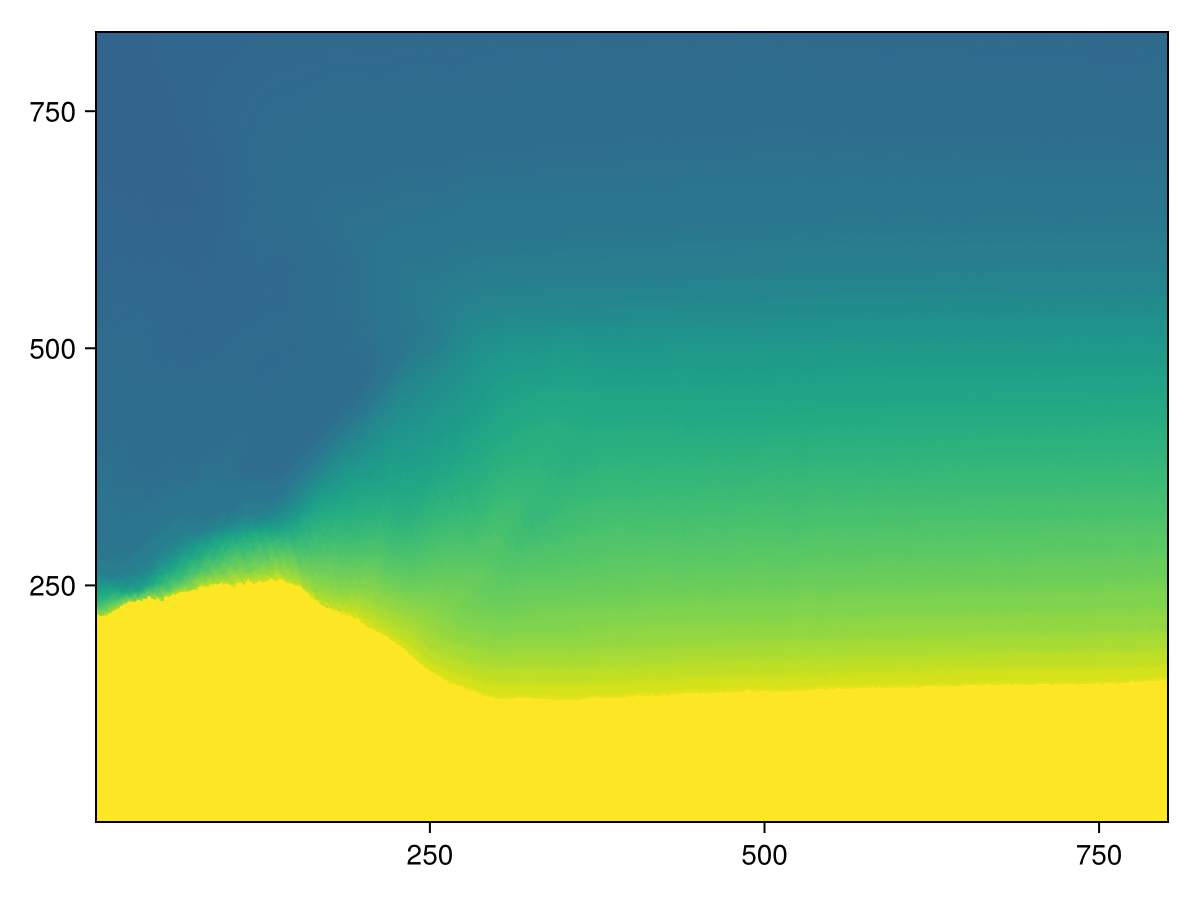

In [48]:
b_dfm = timeseries_of(a->filt(a, 1)[inds, :], joinpath(foldername, "DFM.jld2"), "b_dfm", iterations[401:end])
b_dfm = b_dfm .- mean(b_dfm; dims=(2, 3))
heatmap(b_image(b_dfm, zsᶜ, 0.0004), colorrange=(0, 1))

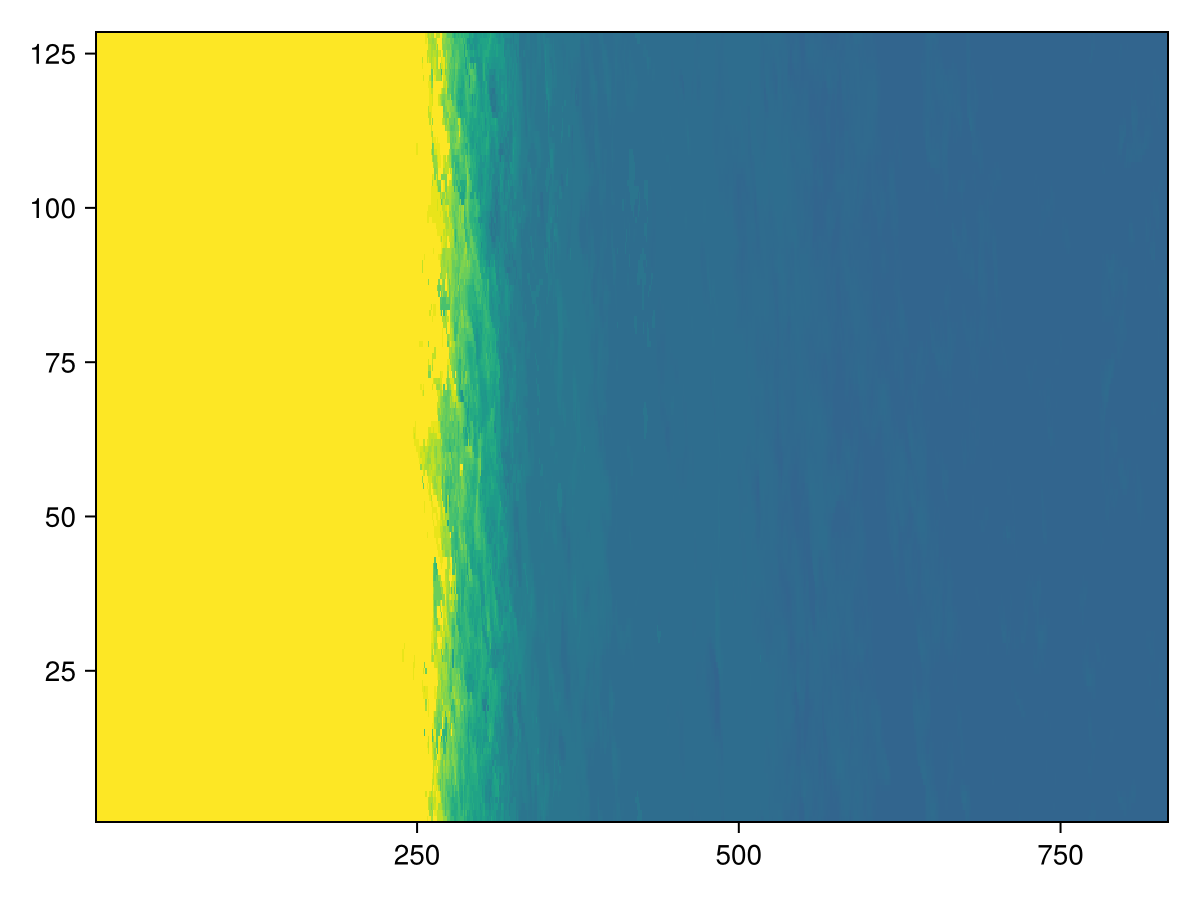

In [74]:
imag = get_field(joinpath(foldername, "output.jld2"), "b", iterations[401]) do field
    repeat(b_image(field[inds, :, :], zsᶜ, -0.0054), 1, 1)
end
heatmap(imag, colorrange=(0, 1))

In [84]:
using Images
colorview(Gray, imag)

LoadError: ArgumentError: Package Images not found in current path.
- Run `import Pkg; Pkg.add("Images")` to install the Images package.

In [ ]:
[-0.0054]

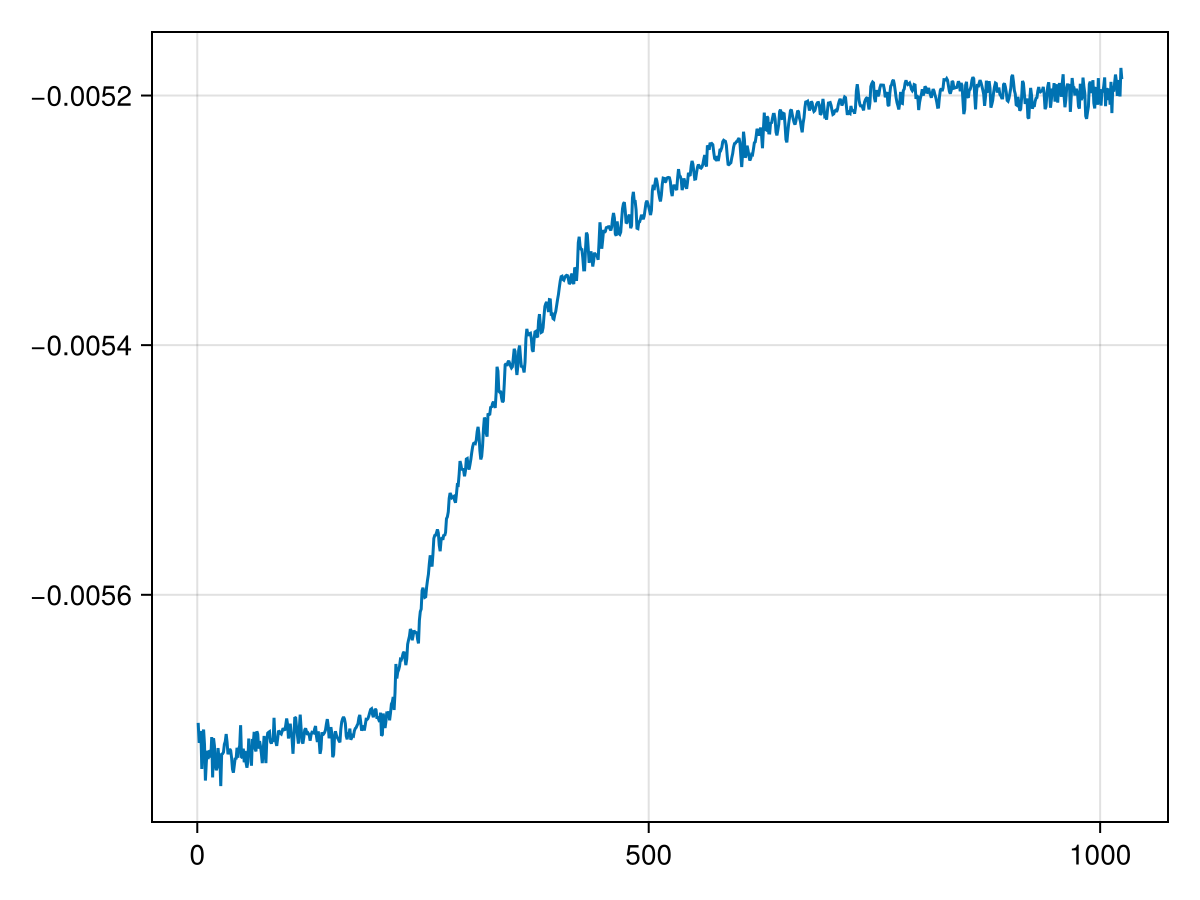

In [70]:
lines(get_field(joinpath(foldername, "output.jld2"), "b", iterations[601])[:, 1, end])

In [53]:
?repeat

search: repeat replace_automatic! KernelFunctionOperation resample_cmap



```
repeat(A::AbstractArray, counts::Integer...)
```

Construct an array by repeating array `A` a given number of times in each dimension, specified by `counts`.

See also: [`fill`](@ref), [`Iterators.repeated`](@ref), [`Iterators.cycle`](@ref).

# Examples

```jldoctest
julia> repeat([1, 2, 3], 2)
6-element Vector{Int64}:
 1
 2
 3
 1
 2
 3

julia> repeat([1, 2, 3], 2, 3)
6×3 Matrix{Int64}:
 1  1  1
 2  2  2
 3  3  3
 1  1  1
 2  2  2
 3  3  3
```

---

```
repeat(A::AbstractArray; inner=ntuple(Returns(1), ndims(A)), outer=ntuple(Returns(1), ndims(A)))
```

Construct an array by repeating the entries of `A`. The i-th element of `inner` specifies the number of times that the individual entries of the i-th dimension of `A` should be repeated. The i-th element of `outer` specifies the number of times that a slice along the i-th dimension of `A` should be repeated. If `inner` or `outer` are omitted, no repetition is performed.

# Examples

```jldoctest
julia> repeat(1:2, inner=2)
4-element Vector{Int64}:
 1
 1
 2
 2

julia> repeat(1:2, outer=2)
4-element Vector{Int64}:
 1
 2
 1
 2

julia> repeat([1 2; 3 4], inner=(2, 1), outer=(1, 3))
4×6 Matrix{Int64}:
 1  2  1  2  1  2
 1  2  1  2  1  2
 3  4  3  4  3  4
 3  4  3  4  3  4
```

---

```
repeat(s::AbstractString, r::Integer)
```

Repeat a string `r` times. This can be written as `s^r`.

See also [`^`](@ref :^(::Union{AbstractString, AbstractChar}, ::Integer)).

# Examples

```jldoctest
julia> repeat("ha", 3)
"hahaha"
```

---

```
repeat(c::AbstractChar, r::Integer) -> String
```

Repeat a character `r` times. This can equivalently be accomplished by calling [`c^r`](@ref :^(::Union{AbstractString, AbstractChar}, ::Integer)).

# Examples

```jldoctest
julia> repeat('A', 3)
"AAA"
```

---

```
repeat(df::AbstractDataFrame; inner::Integer = 1, outer::Integer = 1)
```

Construct a data frame by repeating rows in `df`. `inner` specifies how many times each row is repeated, and `outer` specifies how many times the full set of rows is repeated.

Metadata: this function preserves table-level and column-level `:note`-style metadata.

# Example

```jldoctest
julia> df = DataFrame(a=1:2, b=3:4)
2×2 DataFrame
 Row │ a      b
     │ Int64  Int64
─────┼──────────────
   1 │     1      3
   2 │     2      4

julia> repeat(df, inner=2, outer=3)
12×2 DataFrame
 Row │ a      b
     │ Int64  Int64
─────┼──────────────
   1 │     1      3
   2 │     1      3
   3 │     2      4
   4 │     2      4
   5 │     1      3
   6 │     1      3
   7 │     2      4
   8 │     2      4
   9 │     1      3
  10 │     1      3
  11 │     2      4
  12 │     2      4
```

---

```
repeat(df::AbstractDataFrame, count::Integer)
```

Construct a data frame by repeating each row in `df` the number of times specified by `count`.

Metadata: this function preserves table-level and column-level `:note`-style metadata.

# Example

```jldoctest
julia> df = DataFrame(a=1:2, b=3:4)
2×2 DataFrame
 Row │ a      b
     │ Int64  Int64
─────┼──────────────
   1 │     1      3
   2 │     2      4

julia> repeat(df, 2)
4×2 DataFrame
 Row │ a      b
     │ Int64  Int64
─────┼──────────────
   1 │     1      3
   2 │     2      4
   3 │     1      3
   4 │     2      4
```
